In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Pandas display options to show all columns and all rows if necessary. Puts a lot of strain of processor

In [38]:
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
pd.options.display.float_format= '{:.2f}'.format

In [4]:
ticker_names = pd.read_csv(os.path.join('Resources', 'other-listed.csv')).rename(columns={'ACT Symbol':'Ticker'}).\
drop(columns=['Security Name', 'Exchange', 'CQS Symbol',
       'ETF', 'Round Lot Size', 'Test Issue', 'NASDAQ Symbol'])


nyse = pd.read_csv(os.path.join('Resources', 'nyse.csv'))
nasdaq = pd.read_csv(os.path.join('Resources', 'nasdaq.csv'))
frames = [nyse, nasdaq]

tickers = pd.concat(frames).sort_values(by='Ticker')

In [5]:
data_2018 = pd.read_csv(os.path.join('Resources', '2018_Financial_Data.csv')).\
rename(columns={'Unnamed: 0':'Ticker'}).\
sort_values(by='Ticker').\
reset_index(drop=True)

df = tickers.merge(data_2018, on='Ticker')

## Conditional Filtering

In [135]:
tickers[tickers['Ticker'].str.startswith('SP') == True];

In [127]:
tickers[tickers['Company Name'].str.contains('ETF') == True]

In [132]:
df[df['Sector'] == "Consumer Cyclical"];

## Graphs and Visualizations

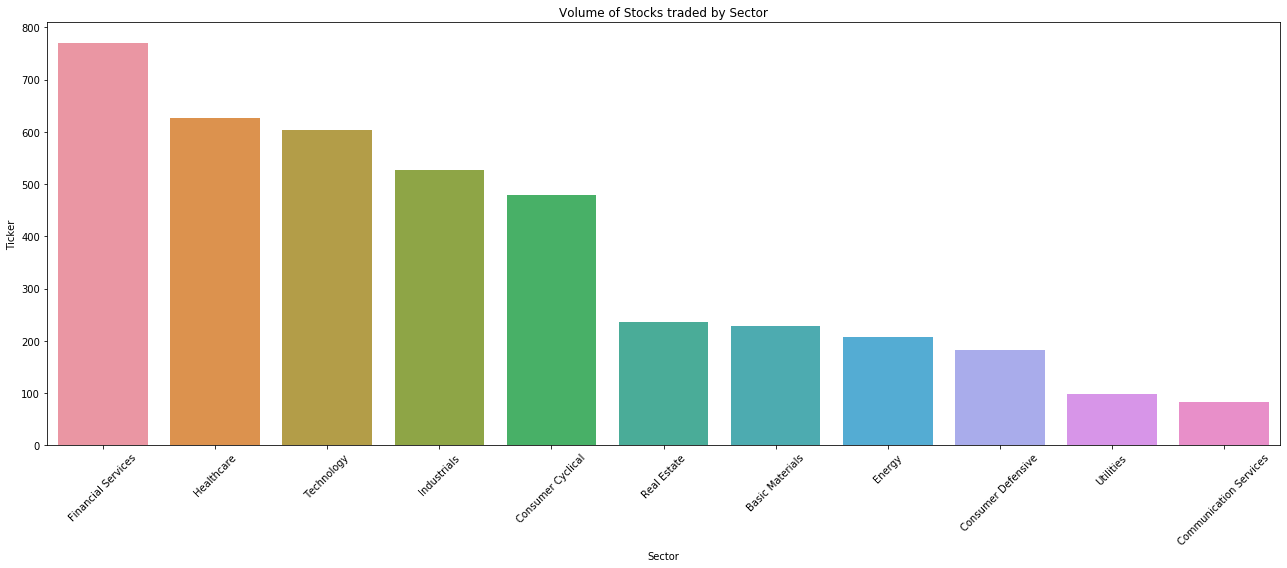

In [130]:
sector_count = pd.DataFrame(df.groupby(['Sector']).count()['Ticker']).reset_index().sort_values(by='Ticker', ascending=False)

plt.figure(figsize=(18,8))
plt.title('Volume of Stocks traded by Sector')
sns.barplot(x = sector_count['Sector'], y = sector_count['Ticker']).set_xticklabels(labels = sector_count['Sector'], rotation=45)
plt.tight_layout()
# plt.savefig(os.path.join('Figures','StockVolume_Sector.png'))

In [ ]:
# df.to_csv(os.path.join('2018_data.csv'))